In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from category_encoders.target_encoder import TargetEncoder

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score
from yellowbrick.classifier import ROCAUC

%matplotlib inline
pd.options.display.max_columns = 400

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [3]:
train.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,f12246592,50d7ad46a,ec69236eb,4ade6ab69,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,5b0f5acd5,1fe17a1fd,04ddac2be,cb43ab175,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [4]:
# create encoders for binary and ordinal features
bin_3_encoder = LabelEncoder().fit(['F', 'T'])
bin_4_encoder = LabelEncoder().fit(['N', 'Y'])
ord_1_encoder = LabelEncoder().fit(["Novice", "Contributor", "Expert", "Master", "Grandmaster"])
ord_2_encoder = LabelEncoder().fit(["Freezing", "Cold", "Warm", "Hot", "Boiling Hot", "Lava Hot"])
ord_3_encoder = LabelEncoder().fit(sorted(train['ord_3'].unique().tolist()))
ord_4_encoder = LabelEncoder().fit(sorted(train['ord_4'].unique().tolist()))
ord_5_encoder = LabelEncoder().fit(sorted(train['ord_5'].unique().tolist()))

# try target encoder for nominal features
nominal_encoder = TargetEncoder().fit(train[['nom_0', 'nom_1','nom_2', 'nom_3', 'nom_4', 
                                             'nom_5','nom_6', 'nom_7','nom_8', 'nom_9']], train['target'])

In [5]:
# create pipeline
def processing_pipeline(input_df):
    df = input_df.copy()
    
    df['bin_3'] = bin_3_encoder.transform(df['bin_3'])
    df['bin_4'] = bin_4_encoder.transform(df['bin_4'])
    df['ord_1'] = ord_1_encoder.transform(df['ord_1'])
    df['ord_2'] = ord_2_encoder.transform(df['ord_2'])
    df['ord_3'] = ord_3_encoder.transform(df['ord_3'])
    df['ord_4'] = ord_4_encoder.transform(df['ord_4'])
    df['ord_5'] = ord_5_encoder.transform(df['ord_5'])
    
    # create cyclic encoding for time features
    df['day_sin'] = np.sin(2*np.pi*(df['day'] / 7))
    df['day_cos'] = np.cos(2*np.pi*(df['day'] / 7))
    df['month_sin'] = np.sin(2*np.pi*(df['month'] / 12))
    df['month_cos'] = np.cos(2*np.pi*(df['month'] / 12))
    df = df.drop(['day', 'month'], axis=1)
    
    nominals = ['nom_0', 'nom_1','nom_2', 'nom_3', 'nom_4', 'nom_5','nom_6', 'nom_7','nom_8', 'nom_9']
    df[nominals] = nominal_encoder.transform(df[nominals])
    df = df.drop('id', axis=1)
    
    return df

In [6]:
proc_train = processing_pipeline(train)
proc_test = processing_pipeline(test)

In [7]:
# create normaliser for ordinal features
ordinals = ['ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5']
ord_normaliser = MinMaxScaler().fit(proc_train[ordinals])
proc_train[ordinals] = ord_normaliser.transform(proc_train[ordinals])
proc_test[ordinals] = ord_normaliser.transform(proc_test[ordinals])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [8]:
# define model and evaluation functions
def modeling(model, proc_train=proc_train):
    X = proc_train.drop('target', axis=1)
    y = proc_train['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    pred_test = []
    
    # 5 folder cross validation
    kf = KFold(n_splits=5)
    kf_iter = 1
    for train_index, test_index in kf.split(X):
        print("KF Iteration: {}".format(kf_iter))
        X_dev, X_val = X.loc[train_index], X.loc[test_index]
        y_dev, y_val = y.loc[train_index], y.loc[test_index]
        
        val_model = model.fit(X_dev, y_dev)
        roc_auc = roc_auc_score(y_val, val_model.predict_proba(X_val)[:,1])
        pred_test.append(val_model.predict_proba(proc_test)[:,1])
        print("ROCAUC score: {}".format(roc_auc))
        kf_iter += 1
    
    print("==========================")
    final_model = model.fit(X_train, y_train)
    test_roc_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:,1])
    print("Test ROCAUC score: {}".format(roc_auc))
    
    visualizer = ROCAUC(final_model, classes=["0", "1"])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()  
    
    return final_model, pred_test

KF Iteration: 1
ROCAUC score: 0.8060180566272556
KF Iteration: 2
ROCAUC score: 0.8042711088207268
KF Iteration: 3
ROCAUC score: 0.8105931464047869
KF Iteration: 4
ROCAUC score: 0.808706065569682
KF Iteration: 5
ROCAUC score: 0.8105446634139222
Test ROCAUC score: 0.8105446634139222


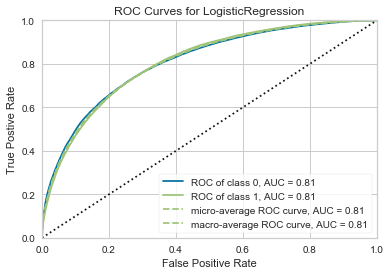

In [9]:
lr_model, pred_test  = modeling(LogisticRegression(solver='lbfgs', 
                                                   max_iter=500, 
                                                   class_weight='balanced', 
                                                   n_jobs=7,
                                                   random_state=42))

In [22]:
pd.DataFrame({'id': test['id'], 
             'target': sum(pred_test) / 5}).to_csv('../submissions/submission_20191016.csv', index=False)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='warn', n_jobs=7, penalty='l2', random_state=42,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [24]:
pd.DataFrame({'id': test['id'], 
             'target': lr_model.predict_proba(proc_test)[:,1]}).to_csv('../submissions/submission_20191016-2.csv', index=False)